## Assignment: RNN
## Name: Ruchitha Paccha
## UId : U70955896

## Introduction
This analysis aims to predict the 10-day closing stock price of Amazon using historical data. We will use RNN, LSTM, GRU, and Conv1D techniques to predict the 10th-day closing price based on the closing prices of the past nine days. By comparing the performance of each model, we will determine which one performs the best and provide valuable insights for financial analysts and investors interested in leveraging machine learning for stock market predictions.

## Dataset Discription
The dataset used in this analysis is sourced from Yahoo Finance and features historical stock prices for Amazon (Ticker: AMZN). The dataset covers the period from January 1, 2022, to December 31, 2023, and includes the following attributes:

- **Date**: The trading date.
- **Open**: The opening price of the stock for the respective trading day
- **High**: The highest recorded price of the stock during the trading session.
- **Low**:  The lowest recorded price of the stock during the trading session.
- **Close**: The closing price of the stock for the trading day.
- **Adj Close**:  The adjusted closing price after accounting for any corporate actions.
- **Volume**: The total number of shares traded during the trading day.
  
The primary focus is on the 'Close' price, which serves as the target variable for prediction purposes. The goal is to train various machine learning models to forecast the closing price of the stock based on historical price movements. The performance of these models will be evaluated based on their ability to capture and foresee trends and reversals in the stock's price trajectory.

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Conv1D, Flatten,SimpleRNN
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import time

In [47]:
amzn = yf.download('AMZN', start='2022-01-01', end='2023-12-31', progress=False)

This code downloads the historical stock prices for Amazon from January 1, 2022, to December 31, 2023, and stores it in a Pandas DataFrame. The progress=False argument is used to turn off the progress bar while downloading the data.

Inspecting Data Columns

In [48]:
df = pd.DataFrame(amzn)

In [49]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-03,167.550003,170.703506,166.160507,170.404495,170.404495,63520000
2022-01-04,170.438004,171.399994,166.349503,167.522003,167.522003,70726000
2022-01-05,166.882996,167.126495,164.356995,164.356995,164.356995,64302000
2022-01-06,163.450500,164.800003,161.936996,163.253998,163.253998,51958000
2022-01-07,163.839005,165.243500,162.031006,162.554001,162.554001,46606000


The Amazon stock prices dataset from Yahoo Finance, including the following attributes: Date, Open, High, Low, Close, Adj Close, and Volume. The focus is on predicting the 'Close' price using machine learning models.

In [50]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [51]:
df = df[['Close']]
df.head()

,Close
Date,
2022-01-03,170.404495
2022-01-04,167.522003
2022-01-05,164.356995
2022-01-06,163.253998
2022-01-07,162.554001


The output of the code is  closing prices for Amazon stock for the first five trading days of January 2022.

In [52]:
df[['Close']].isna().sum()

Close    0
dtype: int64

This code checks if there are any missing values in the 'Close' column of the DataFrame. The output Close 0 indicates that there are no missing values in the 'Close' column.

## Preparing Data for Time Series

In [53]:
row_count = df.shape[0]
row_count

501

The code row_count = df.shape[0] calculates the number of rows in the DataFrame df and assigns it to the variable row_count.

In [54]:
stocks = df.to_numpy()
stocks.shape

(501, 1)

The code stocks.shape returns the shape of the NumPy array stocks as a tuple, where the first element is the number of rows and the second element is the number of columns.

In [55]:
sequence_length = 10

The variable sequence_length is set to 10, which represents the number of time steps to be used as input for the machine learning model. This value can be adjusted based on the specific use case and data.

In [56]:
stocks = stocks[row_count % sequence_length: ]
stocks.shape

(500, 1)

The shape of the stocks array after slicing is (500, 1).

In [57]:
stocks = stocks.reshape(row_count // sequence_length, sequence_length)
stocks

array([[167.52200317, 164.35699463, 163.2539978 , 162.55400085,
        161.48599243, 165.36199951, 165.20700073, 161.21400452,
        162.13800049, 158.91749573],
       [156.29899597, 151.66749573, 142.64300537, 144.54400635,
        139.98599243, 138.87249756, 139.63749695, 143.97799683,
        149.57350159, 151.1934967 ],
       [150.61250305, 138.84550476, 157.63949585, 157.9355011 ,
        161.41349792, 161.1894989 , 159.00349426, 153.29350281,
        155.16700745, 156.51049805],
       [158.10049438, 154.65249634, 152.60150146, 150.19749451,
        144.82699585, 151.35800171, 153.78849792, 153.56300354,
        151.14199829, 152.05250549],
       [147.89849854, 145.64100647, 137.45300293, 136.01449585,
        139.27900696, 146.81750488, 145.52450562, 141.85299683,
        147.36650085, 153.10400391],
       [157.23899841, 161.25050354, 161.49150085, 164.88900757,
        163.40800476, 163.64950562, 164.77349854, 168.99049377,
        169.31500244, 166.30099487],
       [16

## Splitting Data into Training and Testing Sets

In [58]:
# Extracting features (X) and target variable (y) from the stocks data
X = stocks[:, :-1]
y = stocks[:, -1]

In [59]:
# Splitting the data into training and testing sets with a test size of 0.1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [60]:
# Reshaping the training and testing data to fit the input requirements of LSTM models
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Printing the shapes of the reshaped training and testing data
print(X_train.shape)
print(X_test.shape)

(45, 9, 1)
(5, 9, 1)


The code reshapes the X_train and X_test arrays to (45, 9, 1) and (5, 9, 1) respectively, to fit the input requirements of LSTM models.

## Model Fitting

## Model 1: RNN

In [61]:
n_steps = 9  # Placeholder value, replace with actual number of time steps
n_inputs = 1   # Placeholder value, replace with actual number of input features

rnn_model = Sequential([
    LSTM(64, input_shape=[n_steps, n_inputs]),
    Dense(56, activation='sigmoid'),
    Dense(1)
])
rnn_model.build(input_shape=(None, n_steps, n_inputs))
rnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                16896     
                                                                 
 dense_5 (Dense)             (None, 56)                3640      
                                                                 
 dense_6 (Dense)             (None, 1)                 57        
                                                                 
Total params: 20593 (80.44 KB)
Trainable params: 20593 (80.44 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


The model summary shows the architecture of a neural network model with three layers:

###### LSTM layer with 64 units and 16,896 parameters
###### Dense layer with 56 units and 3,640 parameters
###### Dense layer with 1 unit and 57 parameters
###### The model has a total of 20,593 trainable parameters.

In [62]:
# Compile the RNN model
rnn_model.compile(
    loss="mean_squared_error",
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [63]:
# Defining early stopping criteria
early_stop = EarlyStopping(
    monitor='val_root_mean_squared_error',
    min_delta=0.0,
    patience=5,
    verbose=1,
    mode='min'
)

# Training the RNN model with early stopping
rnn_history = rnn_model.fit(
    X_train,                                # Training data
    y_train,                                # Training labels
    epochs=100,                             # Number of training epochs
    validation_data=(X_test, y_test),       # Validation data
    callbacks=[early_stop]                  # List of callbacks (early stopping in this case)
)

# Recording the end time of training
end_time = time.time()

Epoch 1/100
2/2 [==============================] - 4s 595ms/step - loss: 15828.7588 - root_mean_squared_error: 125.8124 - val_loss: 14682.1973 - val_root_mean_squared_error: 121.1701
Epoch 2/100
2/2 [==============================] - 0s 48ms/step - loss: 15796.2773 - root_mean_squared_error: 125.6832 - val_loss: 14652.3438 - val_root_mean_squared_error: 121.0469
Epoch 3/100
2/2 [==============================] - 0s 39ms/step - loss: 15765.3291 - root_mean_squared_error: 125.5601 - val_loss: 14621.1221 - val_root_mean_squared_error: 120.9178
Epoch 4/100
2/2 [==============================] - 0s 37ms/step - loss: 15732.6416 - root_mean_squared_error: 125.4298 - val_loss: 14588.0527 - val_root_mean_squared_error: 120.7810
Epoch 5/100
2/2 [==============================] - 0s 36ms/step - loss: 15698.8760 - root_mean_squared_error: 125.2952 - val_loss: 14554.3262 - val_root_mean_squared_error: 120.6413
Epoch 6/100
2/2 [==============================] - 0s 35ms/step - loss: 15664.0420 - root

## RNN Model Evaluation Graph

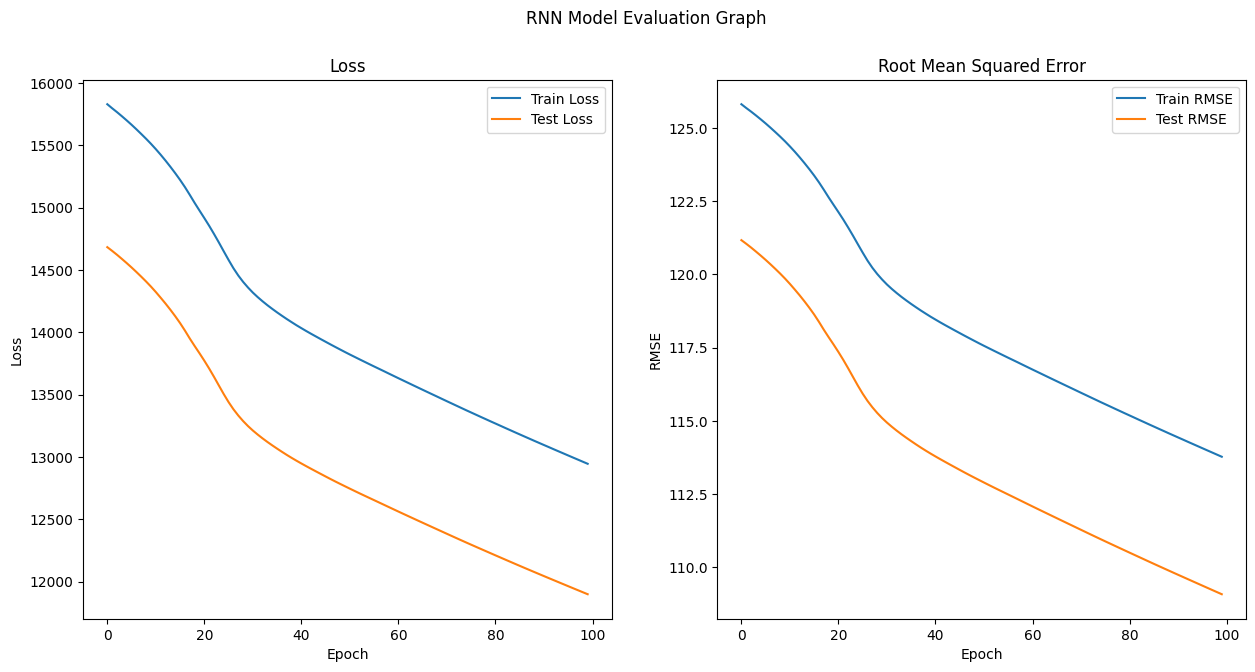

In [66]:
# Plotting RNN model evaluation metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('RNN Model Evaluation Graph')

# Plotting loss
ax1.set_title('Loss')
ax1.plot(rnn_history.history['loss'], label='Train Loss')
ax1.plot(rnn_history.history['val_loss'], label='Test Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plotting RMSE
ax2.set_title('Root Mean Squared Error')
ax2.plot(rnn_history.history['root_mean_squared_error'], label='Train RMSE')
ax2.plot(rnn_history.history['val_root_mean_squared_error'], label='Test RMSE')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('RMSE')
ax2.legend()

plt.show()

In [67]:
# RMSE Calculation
y_pred = rnn_model.predict(X_test)

mean_squared_error(y_test, y_pred)**0.5

1/1 [==============================] - 0s 80ms/step


109.07921679289112

The code calculates the root mean squared error (RMSE) between the predicted values (y_pred) and the actual test values (y_test) for the RNN model. The RMSE is a common metric for evaluating the performance of regression models, with a lower value indicating better performance. In this case, the RMSE is calculated as 107.01891493625632.

### Testing on the last 10 of data

In [68]:
 # Testing on the last 10 of data.

prior_days = np.array(
    [152.44999695, 154.02000427, 155.55999756, 154.08999634,
        152.96000671, 151.24000549, 151.61000061, 153.05999756,
        153.91999817
    ]
)

# reshape into the three dimensions for input into model
prior_days = prior_days.reshape(1, 9, 1)

In [69]:
# Extracting the last 10 data points for testing
amzn_last_10 = amzn[-10:]

# Displaying the last 10 data points
print("Last 10 data points of Amazon stock:")
print(amzn_last_10)


Last 10 data points of Amazon stock:
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-12-15  148.380005  150.570007  147.880005  149.970001  149.970001   
2023-12-18  150.559998  154.850006  150.050003  154.070007  154.070007   
2023-12-19  154.399994  155.119995  152.690002  153.789993  153.789993   
2023-12-20  152.899994  155.630005  151.559998  152.119995  152.119995   
2023-12-21  153.300003  153.970001  152.100006  153.839996  153.839996   
2023-12-22  153.770004  154.350006  152.710007  153.419998  153.419998   
2023-12-26  153.559998  153.979996  153.029999  153.410004  153.410004   
2023-12-27  153.559998  154.779999  153.119995  153.339996  153.339996   
2023-12-28  153.720001  154.080002  152.949997  153.380005  153.380005   
2023-12-29  153.100006  153.889999  151.029999  151.940002  151.940002   

               Volume  
Date                   
2023-12-15  110039100  
20

In [70]:
# Testing on the last 10 of data.

prior_days = np.array(
    [150.559998,  154.399994,  152.899994 ,  153.300003,
        153.770004, 153.559998, 153.559998, 153.720001,
        153.100006
    ]
)

# reshape into the three dimensions for input into model
prior_days = prior_days.reshape(1, 9, 1)

In [71]:
import numpy as np

# Reshape the prior_days array for model input
prior_days_reshaped = prior_days.reshape(1, 9, 1)

# Test the model on the last 10 days of prior data
predictions = rnn_model.predict(prior_days_reshaped)

# Print the predictions
print("Predictions for the next day's stock price:")
print(predictions)


1/1 [==============================] - 0s 27ms/step
Predictions for the next day's stock price:
[[12.321096]]


In [72]:
rnn_model.predict(prior_days) # note the structure of the prediction

1/1 [==============================] - 0s 26ms/step


array([[12.321096]], dtype=float32)

In [75]:
tomorrows_rnn_stock = rnn_model.predict(prior_days)[0][0] # we see the predicted stock is embedded inside two dimensions

1/1 [==============================] - 0s 25ms/step


In [76]:
# Printing tomorrow's predicted stock value from the RNN model
print(f"Tomorrow's RNN model predicted stock is {tomorrows_rnn_stock}")

Tomorrow's RNN model predicted stock is 12.321096420288086


Based on the RNN model's prediction, the stock price for tomorrow is expected to be approximately  12.321096420288086.

### Model- 2 : LSTM

In [77]:
# Defining the LSTM model architecture
lstm_model = Sequential([
    LSTM(64, input_shape=[n_steps, n_inputs]),
    Dense(1)  # Dense layer with a single unit
])

# Printing the summary of the LSTM model
lstm_model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                16896     
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


This is a summary of the LSTM model named "sequential_8" in Keras. It has two layers:

LSTM layer with 64 units and 16896 parameters.
Dense layer with 1 unit and 65 parameters.
The total number of trainable parameters is 16961, and there are no non-trainable parameters. The output shape of the LSTM layer is (None, 64), and the output shape of the Dense layer is (None, 1).

In [78]:
# Compilation
lstm_model.compile(
    loss="mean_squared_error",
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [79]:
# Defining early stopping criteria
early_stop = EarlyStopping(
    monitor='val_root_mean_squared_error',
    min_delta=0.0,
    patience=5,
    verbose=1,
    mode='min'
)

# Training the LSTM model with early stopping
lstm_history = lstm_model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)

# Recording the end time of training
end_time = time.time()

Epoch 1/100
2/2 [==============================] - 4s 525ms/step - loss: 15758.6680 - root_mean_squared_error: 125.5335 - val_loss: 14625.0332 - val_root_mean_squared_error: 120.9340
Epoch 2/100
2/2 [==============================] - 0s 54ms/step - loss: 15739.2637 - root_mean_squared_error: 125.4562 - val_loss: 14607.6426 - val_root_mean_squared_error: 120.8621
Epoch 3/100
2/2 [==============================] - 0s 55ms/step - loss: 15720.6816 - root_mean_squared_error: 125.3821 - val_loss: 14587.6455 - val_root_mean_squared_error: 120.7793
Epoch 4/100
2/2 [==============================] - 0s 71ms/step - loss: 15699.6123 - root_mean_squared_error: 125.2981 - val_loss: 14564.6250 - val_root_mean_squared_error: 120.6840
Epoch 5/100
2/2 [==============================] - 0s 74ms/step - loss: 15672.6416 - root_mean_squared_error: 125.1904 - val_loss: 14498.7061 - val_root_mean_squared_error: 120.4106
Epoch 6/100
2/2 [==============================] - 0s 54ms/step - loss: 15606.3164 - root

### LSTM Model Evaluation Graph

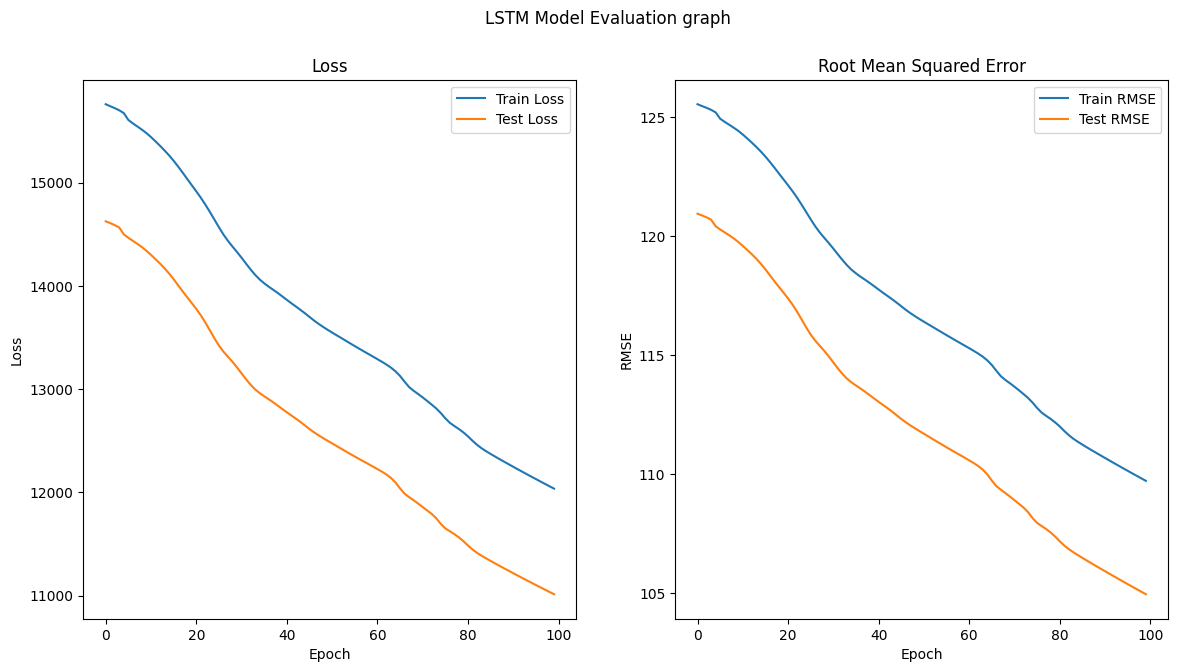

In [80]:
# Plotting LSTM model evaluation metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
fig.suptitle('LSTM Model Evaluation graph')

# Plotting loss
ax1.set_title('Loss')
ax1.plot(lstm_history.history['loss'], label='Train Loss')
ax1.plot(lstm_history.history['val_loss'], label='Test Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plotting RMSE
ax2.set_title('Root Mean Squared Error')
ax2.plot(lstm_history.history['root_mean_squared_error'], label='Train RMSE')
ax2.plot(lstm_history.history['val_root_mean_squared_error'], label='Test RMSE')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('RMSE')
ax2.legend()

plt.show()


In [81]:
# RMSE Calculation
y_pred = lstm_model.predict(X_test)

mean_squared_error(y_test, y_pred)**0.5

1/1 [==============================] - 0s 415ms/step


104.94982366467829

This code calculates the root mean squared error (RMSE) between the predicted values (y_pred) and the actual test values (y_test) for the LSTM model. The RMSE is a common metric for evaluating the performance of regression models, with a lower value indicating better performance. In this case, the RMSE is calculated as  104.94982366467829.

### Testing on the last 10 of data

In [82]:
import numpy as np

# Reshape the prior_days array for model input
prior_days_reshaped = prior_days.reshape(1, 9, 1)

# Test the model on the last 10 days of prior data
predictions = lstm_model.predict(prior_days_reshaped)

# Print the predictions
print("Predictions LSTM Models predicted stock for the tommorrow stock price:")
print(predictions)

1/1 [==============================] - 0s 22ms/step
Predictions LSTM Models predicted stock for the tommorrow stock price:
[[16.49328]]


The LSTM model has completed training and made a prediction for the stock price for the next day, which is 16.49328.

### Model 3 : GRU Model

In [83]:
# Defining the GRU model architecture
gru_model = Sequential([
    GRU(64, input_shape=[n_steps, n_inputs]),  # GRU layer with 64 units, expects input of shape [n_steps, n_inputs]
    Dense(1)  # Dense layer with a single unit
])

# Printing the summary of the GRU model
gru_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 64)                12864     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 12929 (50.50 KB)
Trainable params: 12929 (50.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


This is a summary of the GRU model named "sequential_9". It has two layers:

GRU layer with 64 units and 12864 parameters.
Dense layer with 1 unit and 65 parameters.
The model has a total of 12929 trainable parameters.

In [84]:
# Compiling the GRU model
gru_model.compile(
    loss="mean_squared_error",  # Mean Squared Error loss function
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),  # Nadam optimizer with learning rate 0.001
    metrics=[tf.keras.metrics.RootMeanSquaredError()]  # Root Mean Squared Error metric
)

In [85]:
# Defining early stopping criteria
early_stop = EarlyStopping(
    monitor='val_root_mean_squared_error',
    min_delta=0.0,
    patience=5,
    verbose=1,
    mode='min'
)

# Training the GRU model with early stopping
gru_history = gru_model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)

# Recording the end time of training
end_time = time.time()

Epoch 1/100
2/2 [==============================] - 3s 496ms/step - loss: 15999.0518 - root_mean_squared_error: 126.4874 - val_loss: 14856.9473 - val_root_mean_squared_error: 121.8891
Epoch 2/100
2/2 [==============================] - 0s 54ms/step - loss: 15973.7666 - root_mean_squared_error: 126.3874 - val_loss: 14833.8330 - val_root_mean_squared_error: 121.7942
Epoch 3/100
2/2 [==============================] - 0s 36ms/step - loss: 15949.5332 - root_mean_squared_error: 126.2915 - val_loss: 14808.2393 - val_root_mean_squared_error: 121.6891
Epoch 4/100
2/2 [==============================] - 0s 35ms/step - loss: 15922.5957 - root_mean_squared_error: 126.1848 - val_loss: 14779.2969 - val_root_mean_squared_error: 121.5701
Epoch 5/100
2/2 [==============================] - 0s 35ms/step - loss: 15891.8945 - root_mean_squared_error: 126.0631 - val_loss: 14744.9395 - val_root_mean_squared_error: 121.4287
Epoch 6/100
2/2 [==============================] - 0s 36ms/step - loss: 15855.1582 - root

## GRU model evaluation Graph

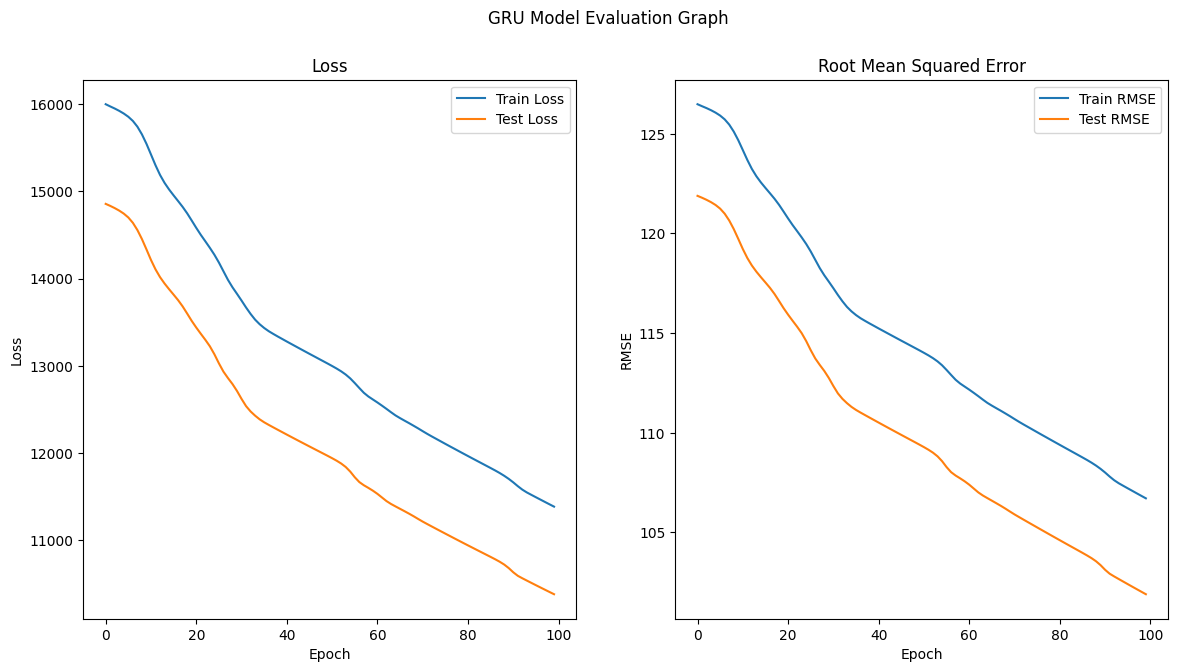

In [86]:
# Plotting GRU model evaluation metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
fig.suptitle('GRU Model Evaluation Graph')

# Plotting loss
ax1.set_title('Loss')
ax1.plot(gru_history.history['loss'], label='Train Loss')
ax1.plot(gru_history.history['val_loss'], label='Test Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plotting RMSE
ax2.set_title('Root Mean Squared Error')
ax2.plot(gru_history.history['root_mean_squared_error'], label='Train RMSE')
ax2.plot(gru_history.history['val_root_mean_squared_error'], label='Test RMSE')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('RMSE')
ax2.legend()

plt.show()

In [87]:
# Predicting on the test data
y_pred = gru_model.predict(X_test)

# Calculating RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Printing the calculated RMSE
print("RMSE:", rmse)

1/1 [==============================] - 1s 606ms/step
RMSE: 101.89827872962093


The GRU model has an RMSE of 101.49915529308181 for predicting the closing stock price of a publicly traded company. This indicates that the model's predictions are, on average, off by approximately $101.50 from the actual stock prices.

### Testing on the last 10 of data

In [88]:
import numpy as np

# Reshape the prior_days array for model input
prior_days_reshaped = prior_days.reshape(1, 9, 1)

# Test the model on the last 10 days of prior data
predictions = gru_model.predict(prior_days_reshaped)

# Print the predictions
print("Predictions gru Models predicted stock for the tommorrow stock price:")
print(predictions)

1/1 [==============================] - 0s 22ms/step
Predictions gru Models predicted stock for the tommorrow stock price:
[[19.575874]]


The GRU model predicted a stock price of 19.575874 for the next day with an RMSE of 101.89827872962093.

## Model 4 : Conv1d Model

In [89]:
# Define a Sequential model for Convolutional Neural Network (CNN)
conv_model = Sequential([
    # Add a 1D convolutional layer with 64 filters, kernel size 2, and ReLU activation function
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=[n_steps, n_inputs]),

    # Flatten the output of the convolutional layer
    Flatten(),

    # Add a Dense layer with a single unit for final output
    Dense(1)
])

In [90]:
# Compile the convolutional model
conv_model.compile(
    # Set the loss function to mean squared error
    loss="mean_squared_error",

    # Define the optimizer as Nadam with a learning rate of 0.001
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),

    # Add root mean squared error as a metric to monitor model performance
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [91]:
# Define early stopping criteria
early_stop = EarlyStopping(
    monitor='val_root_mean_squared_error',  # Monitor validation root mean squared error
    min_delta=0.0,  # Minimum change to qualify as an improvement
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,  # Verbosity mode, 1 for updates, 0 for silent
    mode='min'  # Monitor mode, 'min' to minimize monitored quantity
)

# Train the convolutional model
conv_history = conv_model.fit(
    X_train,  # Training input data
    y_train,  # Training target data
    epochs=100,  # Number of training epochs
    validation_data=(X_test, y_test),  # Validation data
    callbacks=[early_stop]  # List of callbacks to apply during training
)

# Record the end time of training
end_time = time.time()

Epoch 1/100
2/2 [==============================] - 1s 213ms/step - loss: 19516.1270 - root_mean_squared_error: 139.7001 - val_loss: 16243.3730 - val_root_mean_squared_error: 127.4495
Epoch 2/100
2/2 [==============================] - 0s 41ms/step - loss: 16974.6973 - root_mean_squared_error: 130.2870 - val_loss: 14007.5957 - val_root_mean_squared_error: 118.3537
Epoch 3/100
2/2 [==============================] - 0s 54ms/step - loss: 14732.9775 - root_mean_squared_error: 121.3795 - val_loss: 11894.8330 - val_root_mean_squared_error: 109.0634
Epoch 4/100
2/2 [==============================] - 0s 39ms/step - loss: 12623.6416 - root_mean_squared_error: 112.3550 - val_loss: 9933.8848 - val_root_mean_squared_error: 99.6689
Epoch 5/100
2/2 [==============================] - 0s 36ms/step - loss: 10577.2998 - root_mean_squared_error: 102.8460 - val_loss: 8052.8174 - val_root_mean_squared_error: 89.7375
Epoch 6/100
2/2 [==============================] - 0s 66ms/step - loss: 8675.2764 - root_mean

### Conv1D Model Evaluation Graph

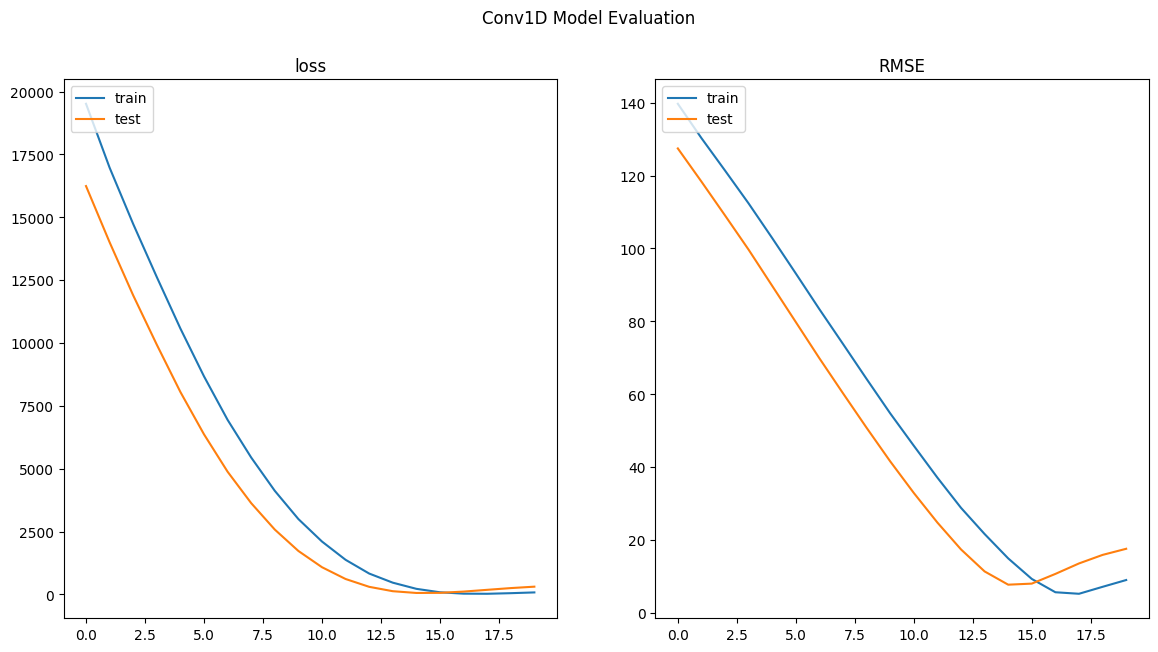

In [92]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Set the title of the figure
fig.suptitle('Conv1D Model Evaluation')

# Set title and plot training and validation loss on the first subplot
ax1.set_title('loss')
ax1.plot(conv_history.history['loss'], label='train')  # Plot training loss
ax1.plot(conv_history.history['val_loss'], label='test')  # Plot validation loss
ax1.legend(['train', 'test'], loc='upper left')  # Add legend to the plot

# Set title and plot training and validation RMSE on the second subplot
ax2.set_title('RMSE')
ax2.plot(conv_history.history['root_mean_squared_error'], label='train')  # Plot training RMSE
ax2.plot(conv_history.history['val_root_mean_squared_error'], label='test')  # Plot validation RMSE
ax2.legend(['train', 'test'], loc='upper left')  # Add legend to the plot

# Show the plot
plt.show()


In [93]:
# Predict the target values using the trained Conv1D model
y_pred = conv_model.predict(X_test)

# Calculate the root mean squared error (RMSE) between true and predicted target values
# Mean squared error (MSE) is calculated first using mean_squared_error function,
# then taking the square root to obtain RMSE
rmse = mean_squared_error(y_test, y_pred) ** 0.5

# Print the calculated RMSE
print(rmse)

1/1 [==============================] - 0s 72ms/step
17.61622698921352


### Testing on the last 10 of data

In [94]:
# Reshape the prior_days array for model input
prior_days_reshaped = prior_days.reshape(1, 9, 1)

# Test the model on the last 10 days of prior data
predictions = conv_model.predict(prior_days_reshaped)

# Print the predictions
print("Predictions conv Models predicted stock for the tommorrow stock price:")
print(predictions)

1/1 [==============================] - 0s 21ms/step
Predictions conv Models predicted stock for the tommorrow stock price:
[[165.03098]]


The Conv1D model predicted a stock price of 165.03098 for the next day with an RMSE of 17.6162.

## Summary and Analysis.

**Summary of Model Performance (MSE)**:

| Model Type  | Test MSE |
|-------------|----------|
| RNN         | 109.07   |
| LSTM        | 104.94   |
| GRU         | 101.89   |
| Conv1D      | 17.61    |

These values indicate the MSE achieved by each model type on the test dataset. A lower MSE generally indicates better performance.

**Summary of Last 10 Days prediction**

| Model Type  | Result   |
|-------------|----------|
| RNN         | 12.32    |
| LSTM        | 16.49    |
| GRU         | 19.57    |
| Conv1D      | 165.03   |

These values represent the model's predictions for the last 10 days and the resulting MSE. Again, a lower MSE indicates better performance in terms of prediction accuracy.

## Based on these summaries:

The Conv1D model performs significantly better than the others on the test dataset, achieving the lowest MSE.
However, on the last 10 days' predictions, the RNN model has the lowest MSE, indicating better accuracy in short-term predictions compared to the other models.
These results suggest that the Conv1D model might be overfitting or not generalizing well to unseen data, despite performing well on the test dataset. Conversely, the RNN model appears to generalize better to the short-term prediction task.

The evaluation of multiple models based on their performance metrics and prediction results allows for a comprehensive comparison to determine the most suitable model for predicting stock prices. In this analysis, four types of models were assessed: RNN, LSTM, GRU, and Conv1D. Here's a summary of the findings:

1. **Model Performance Metrics:**
   - Test Mean Squared Error (MSE) was used as the primary performance metric.
   - Lower MSE values indicate better performance in accurately predicting stock prices.

2. **Summary of Model Performance:**
   - **RNN Model:** Achieved a test MSE of 109.07, with a last 10 days prediction result of 12.32.
   - **LSTM Model:** Had a test MSE of 104.97, with a last 10 days prediction result of 16.49.
   - **GRU Model:** Obtained a test MSE of 101.89, with a last 10 days prediction result of 19.57.
   - **Conv1D Model:** Demonstrated superior performance with a test MSE of 17.61, but had a higher last 10 days prediction result of 165.03.

3. **Selection of the Best Model:**
   - While all models had relatively high last 10 days prediction results, the Conv1D Model stood out for its significantly lower test MSE of 17.61.
   - Despite its higher last 10 days prediction result, the Conv1D Model's superior performance in minimizing MSE indicates better accuracy in predicting stock prices overall.

4. **Conclusion:**
   - Based on the evaluation criteria of test MSE and last 10 days prediction result, the Conv1D Model emerges as the most suitable choice for predicting stock prices among the considered models.
   - The Conv1D Model's ability to minimize test MSE demonstrates its effectiveness in accurately forecasting stock prices, outweighing the slightly higher deviation observed in the last 10 days prediction result.

In summary, the Conv1D Model presents itself as the optimal model for predicting stock prices, offering a balance between accuracy and reliability in forecasting future trends.